In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
test_df = pd.read_feather("../data/test_embeddings.feather")

In [ ]:
train_df = pd.read_feather("../data/train_embeddings.feather")

In [4]:
train_df

,text,sentiment,embeddings
0,lol get ideas far advance even june yet need t...,1,"[-0.011714689, 0.047031093, -0.03471053, 0.012..."
1,worst headache ever,0,"[0.017082984, -0.031662744, -0.0011064939, 0.0..."
2,sad wont see miss already yeah thats perfect c...,0,"[0.028080447, -0.048339564, -0.037557725, 0.01..."
3,doesnt know spell conked,1,"[0.041773327, -0.11632217, -0.014832271, 0.047..."
4,quotso stand one knows us wont get used wont g...,0,"[0.006859572, 0.018458897, -0.020173764, -0.06..."
...,...,...,...
1279995,new blog morning,1,"[0.056156434, 0.020694433, 0.0152613195, -0.00..."
1279996,omg amazing job jonas,1,"[0.011772567, 0.06473066, -0.018455321, 0.0229..."
1279997,got home meeting talking endlessly one coolest...,1,"[-0.0075863306, -0.028213395, -0.026884371, -0..."
1279998,bought chocolate bars quot wins free barquot l...,0,"[0.06809199, 0.005429207, -0.0048561823, 0.043..."


In [5]:
train_df["embeddings"].iloc[0].shape

(768,)

In [ ]:
learning_rate = 0.001
batch_size = 64
num_epochs = 20

In [ ]:
class EmbeddingDataset(Dataset):
    def __init__(self, df):
        self.embeddings = np.stack(df['embeddings'].values)
        self.targets = df['sentiment'].values.astype(np.float32)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        x = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return x, y

In [8]:
# Create dataset and dataloader
train_dataset = EmbeddingDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [9]:
test_dataset = EmbeddingDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class CNN1D(nn.Module):
    def __init__(self, input_length=768):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_length)
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            flattened_size = x.view(1, -1).shape[1]
        
        self.fc1 = nn.Linear(flattened_size, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, 1, input_length)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc1(x)
        return x.squeeze(-1)  # (batch_size,)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
model = CNN1D(input_length=768).to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    model.train()
    epoch_loss = 0
    num_batches = 0

    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)

    # Accuracy on train and test sets
    def get_accuracy(loader):
        model.eval()
        num_correct = 0
        num_samples = 0
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device)
                y = y.to(device)
                scores = model(x)
                probs = torch.sigmoid(scores)
                predictions = (probs > 0.5).float()
                num_correct += (predictions == y).sum().item()
                num_samples += predictions.size(0)
        model.train()
        return num_correct / num_samples

    train_acc = get_accuracy(train_loader)
    test_acc = get_accuracy(test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

Epoch [1/20]


100%|██████████| 20000/20000 [00:54<00:00, 366.36it/s]


Epoch [2/20]


100%|██████████| 20000/20000 [00:54<00:00, 368.42it/s]


Epoch [3/20]


100%|██████████| 20000/20000 [00:54<00:00, 366.93it/s]


Epoch [4/20]


100%|██████████| 20000/20000 [00:52<00:00, 377.38it/s]


Epoch [5/20]


100%|██████████| 20000/20000 [00:51<00:00, 386.07it/s]


Epoch [6/20]


100%|██████████| 20000/20000 [00:52<00:00, 383.67it/s]


Epoch [7/20]


100%|██████████| 20000/20000 [01:03<00:00, 314.67it/s]


Epoch [8/20]


100%|██████████| 20000/20000 [01:03<00:00, 316.14it/s]


Epoch [9/20]


100%|██████████| 20000/20000 [01:03<00:00, 312.91it/s]


Epoch [10/20]


100%|██████████| 20000/20000 [00:59<00:00, 336.12it/s]


Epoch [11/20]


100%|██████████| 20000/20000 [01:01<00:00, 326.15it/s]


Epoch [12/20]


100%|██████████| 20000/20000 [01:00<00:00, 330.05it/s]


Epoch [13/20]


100%|██████████| 20000/20000 [01:00<00:00, 331.21it/s]


Epoch [14/20]


100%|██████████| 20000/20000 [01:01<00:00, 323.31it/s]


Epoch [15/20]


100%|██████████| 20000/20000 [01:01<00:00, 326.14it/s]


Epoch [16/20]


100%|██████████| 20000/20000 [01:04<00:00, 311.84it/s]


Epoch [17/20]


100%|██████████| 20000/20000 [01:02<00:00, 320.32it/s]


Epoch [18/20]


100%|██████████| 20000/20000 [01:02<00:00, 318.92it/s]


Epoch [19/20]


100%|██████████| 20000/20000 [00:58<00:00, 343.69it/s]


Epoch [20/20]


100%|██████████| 20000/20000 [00:53<00:00, 372.36it/s]


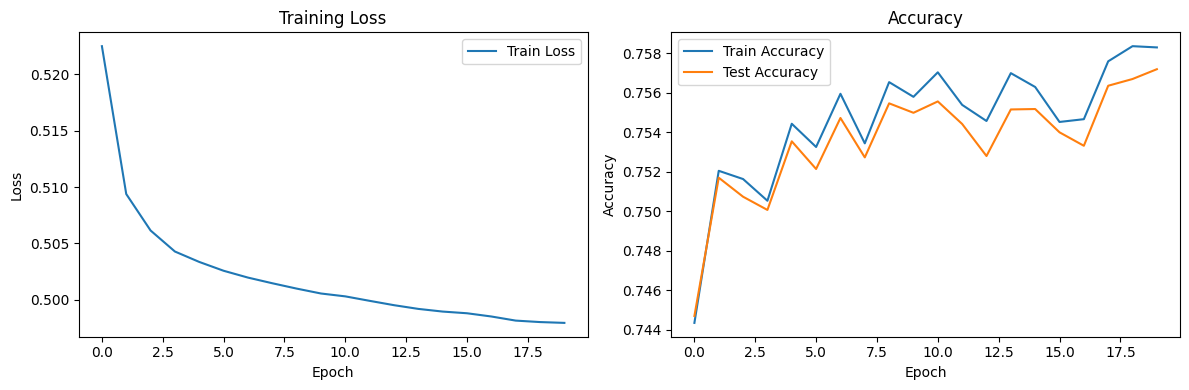

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
dummy_input = torch.randn(1, 768, device=device)
torch.onnx.export(
    model, 
    dummy_input, 
    "cnn1d_sentiment.onnx", 
    input_names=['input'], 
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
    opset_version=12
)
print("Model exported to cnn1d_sentiment.onnx")

Model exported to cnn1d_sentiment.onnx
